In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sympy import Symbol, symbols, solve, lambdify
from sympy import init_printing
init_printing()

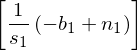

In [3]:
#parameters
s1, b1, mu =  symbols('s1 b1 mu')
#helpers
n1 =  symbols('n1')
#estimators
muhat = symbols('muhat')

nu1 = muhat*s1+b1

#likelihood is L(nu1|n1) = p(n1|nu1) = nu1^*n1 * exp(-nu1)/n1!
#log likelihood is log L(nu1|n1) = n1 log(nu1) - nu1 - log(n1!)

#max likelihood when n1(log(nu1)-1) maximal, i.e. when nu1 maximal
#max(L) when first derivative zero ∂L(nu1,n1)/∂nu1 = n1/nu1 - 1 == 0


#n1/nu1 = 1
#nu1 = n1
#µs+b = n1
#mu^ = (n1-b)/s
#ok trivial but let's run with it
expr = solve( n1/nu1 - 1, muhat)
muhatFunc = lambdify((n1,s1,b1),expr[0],"numpy")
expr

In [4]:
#q(µ) is profile likelihood
#                L(µs+b|n)
#is q(µ) = -2log ---------
#                L(µ^s+b|n)

#q(µ) = -2((Log(µs+b|n) - Log(µ^s+b|n)))
#     = -2 ((n*log(µs+b) - (µs+b)) - (n*log(µ^s+b) - (µ^s+b) ))
#     = -2 ((n*log((µs+b)/(µ^s+b)) + (µ^-µ)s))
#     = -2((µ^-µ)s - (n*log((µ^s+b)/(µs+b))) = -2(µ^s - (n*log((n1)/(µs+b))) # µ^s+b = n1 see above


#q(0) = -2(µ^s - n*log(n1/b))

def qmu(n,s,b,mu):
    muhat = muhatFunc(n,s,b)
    qmu = -2*((muhat-mu)*s - n*np.log(float(n)/float(mu*s+b)))
    return qmu

def q0(n,s,b):
    muhat = muhatFunc(n,s,b)
    q0 = -2*(muhat*s - n*np.log(float(n)/float(b)))
    return q0

In [5]:
def plot_toys_data(obsdata,toys_b,toys_sb):
    maxval = max(max(toys_b),max(toys_sb))
    _,_,_ = plt.hist(toys_b, bins = np.linspace(0,maxval,50))
    _,_,_ = plt.hist(toys_sb, bins = np.linspace(0,maxval,50), alpha = 0.5, color = 'red')
    plt.axvline(x = obsdata, c = 'black', linestyle = 'solid', linewidth = 2)

def plot_means(mutest):
    matplotlib.pyplot.bar([1],mean_b,[0.1], ecolor = 'black')
    matplotlib.pyplot.bar([1],mutest*mean_s,[0.1], ecolor = 'black', bottom = mean_b, color = 'red')

In [6]:
import scipy.stats

def calc_teststat(teststat,obs_data,toys_b,toys_sb):
    #calculate test statistics for toys and observed
    teststat_b = teststat(toys_b)
    teststat_sb = teststat(toys_sb)
    teststat_obs = teststat(obs_data)
    
    #calculate expected test stat values for b-only
    bpercentiles = (ep2,ep1,exp,em1,em2) = [
        np.percentile(teststat_b,x*100) for x in [
            scipy.stats.norm.cdf(x) for x in [2,1,0,-1,-2]]]

    return teststat_b,teststat_sb,teststat_obs,bpercentiles

In [7]:
def calc_pvals(teststat_b,teststat_sb):
    #build the integrals to measure p-values
    binning_opts = (min(min(teststat_b),min(teststat_sb)),max(max(teststat_b),max(teststat_sb)),50)
    b_histo,bindata = np.histogram(teststat_b, bins = np.linspace(*binning_opts))
    sb_histo,bindata = np.histogram(teststat_sb, bins = bindata)
    integral_b = np.cumsum(b_histo)/np.sum(np.float_(b_histo))
    integral_sb = np.cumsum(sb_histo)/np.sum(np.float_(sb_histo))
    def pb(x):
        return 1-np.interp(x,bindata[:-1],integral_b)
    def psb(x):
        return 1-np.interp(x,bindata[:-1],integral_sb)
    return pb,psb
    
def make_test(teststat,obs_data,toys_b,toys_sb):

    tb,tsb,to,bps = calc_teststat(teststat,obs_data,toys_b,toys_sb)

    pb, psb = calc_pvals(tb,tsb)
        
    def CLs(x):
        #we intepolate the cumulative histograms
        return psb(x)/pb(x)
    
    return {
        'CLs_obs':CLs(to),
        'CLs_exp':[CLs(x) for x in bps]
    }

In [8]:
def plot_teststat(teststat_b,teststat_sb,t_obs,percentiles):
    pylab.yscale('symlog',linthreshy=1)
    
    binning_opts = (min(min(teststat_b),min(teststat_sb)),max(max(teststat_b),max(teststat_sb)),50)

    b_histo,bindata,_ = plt.hist(teststat_b, bins = np.linspace(*binning_opts), alpha = 0.5)
    sb_histo,bindata,_ = plt.hist(teststat_sb, bins = bindata, alpha = 0.5, color = 'red')

    ep2,ep1,exp,em1,em2 = percentiles

    ax = plt.axes()
    ax.set_ylim([0.1,2*sb_histo[0]])
    ax.fill_betweenx([0.1,2*sb_histo[0]], [ep2,ep2], [em2,em2], facecolor='yellow', alpha=0.5)
    ax.fill_betweenx([0.11,2*sb_histo[0]], [ep1,ep1], [em1,em1], facecolor='green', alpha=0.5)

    for xperc,style in zip(percentiles,['dotted','dotted','dashed','dotted','dotted']):
        plt.axvline(x = xperc, c = 'black', linestyle = style)

    plt.axvline(x = t_obs, c = 'black', linestyle = 'solid', linewidth = 2)
    

In [9]:
def plot_vertical(CLs_data):
    pylab.yscale('log')
    ax = plt.axes()
    ax.fill_betweenx([CLs_data['CLs_exp'][0],CLs_data['CLs_exp'][-1]], [0,0], [1,1], facecolor='yellow', alpha=0.5)
    ax.fill_betweenx([CLs_data['CLs_exp'][1],CLs_data['CLs_exp'][-2]], [0,0], [1,1], facecolor='green', alpha=0.5)
    ax.set_ylim([10**(-3),1])
    plt.yticks([10**(-x)for x in range(4)])


    for cls,style in zip(CLs_data['CLs_exp'],['dotted','dotted','dashed','dotted','dotted']):
        plt.axhline(cls, c = 'black', linestyle = style)

    plt.axhline(CLs_data['CLs_obs'], linestyle = 'solid', color = 'black')
    plt.axhline(0.05, color = 'red')

In [10]:
def generate_signaltoys(mutest,mean_s,mean_b,nexpts):
    return np.random.poisson(mutest*mean_s+mean_b,nexpts)

def generate_backgroundtoys(mean_b,nexpts):
    return np.random.poisson(mean_b,nexpts)

In [12]:
def make_test_stat(mu,mean_s,mean_b):
    def test_stat(data):
        return qmu(data,mean_s,mean_b,mu)
    test_stat = np.vectorize(test_stat)
    return test_stat

In [154]:
def plotmuscan(scanmus,scanresults):
    point05cross = {'exp':[],'obs':None}
    for i,style in enumerate(['dotted','dotted','dashed','dotted','dotted']):
        yvals = [x['CLs_exp'][i] for x in scanresults]
        plt.plot(scanmus,yvals,linestyle = style, color = 'black')

        point05cross['exp'].append(np.interp(0.05,list(reversed(yvals)),list(reversed(scanmus))))
        
    yvals = [x['CLs_obs'] for x in scanresults]
    plt.plot(scanmus,yvals,linestyle = 'solid', linewidth = 2, color = 'black')
    point05cross['obs'] = np.interp(0.05,list(reversed(yvals)),list(reversed(scanmus)))

                                   
                                   
    ax = plt.axes()
    ax.fill_between(scanmus, [x['CLs_exp'][-1] for x in scanresults], [x['CLs_exp'][0] for x in scanresults], color = 'yellow')
    ax.fill_between(scanmus, [x['CLs_exp'][-2] for x in scanresults], [x['CLs_exp'][1] for x in scanresults], color = 'green')
    plt.axhline(0.05, color = 'red')

    
    ax.fill_betweenx([1.0,1.2],[point05cross['exp'][0]]*2,[point05cross['exp'][-1]]*2, color = 'yellow')
    ax.fill_betweenx([1.0,1.2],[point05cross['exp'][1]]*2,[point05cross['exp'][-2]]*2, color = 'green')

    
    for x in point05cross['exp']:
        plt.axvline(x, linestyle = 'dashed', color = 'black')
    plt.axvline(point05cross['obs'], linestyle = 'solid', linewidth = 2, color = 'black')


In [156]:
mean_s = 30
mean_b = 200
n_obs = 220
nexpts=50000
toys_b  = generate_backgroundtoys(mean_b,nexpts)

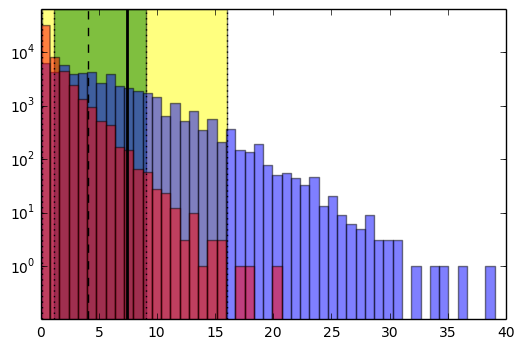

In [122]:
testmu = 1.0
test_stat_mu = make_test_stat(testmu,mean_s,mean_b)
toys_testmu = generate_signaltoys(testmu,mean_s,mean_b,nexpts)
plot_teststat(*calc_teststat(test_stat_mu,n_obs,toys_b,toys_testmu))

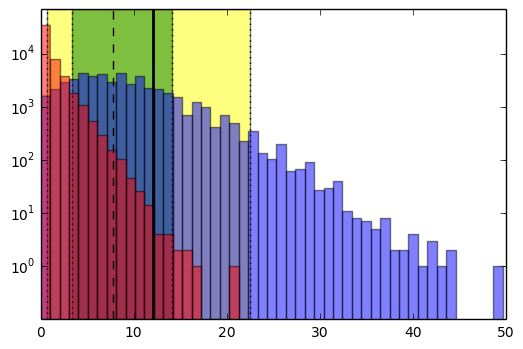

In [105]:
testmu = 1.4
test_stat_mu = make_test_stat(testmu,mean_s,mean_b)
toys_testmu = generate_signaltoys(testmu,mean_s,mean_b,nexpts)

plot_teststat(*calc_teststat(test_stat_mu,n_obs,toys_b,toys_testmu))

In [158]:
results = []
scanmus = np.linspace(0,2.0,10)
for testmu in scanmus:
    test_stat_mu = make_test_stat(testmu,mean_s,mean_b)
    toys_testmu = generate_signaltoys(testmu,mean_s,mean_b,nexpts)
    results.append(make_test(test_stat_mu,n_obs,toys_b,toys_testmu))

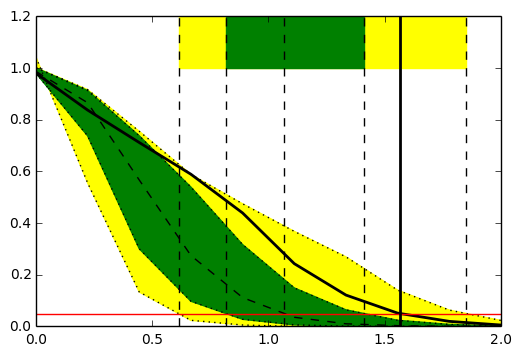

In [159]:
plotmuscan(scanmus,results)